# Introduction

The notebook gives an example of how one can deal with tabular data using tensorflow. 

> This will be a very quick example. For more details, consult the TensorFlow documentation. The material below is following the tutorial https://www.tensorflow.org/tutorials/structured_data/preprocessing_layers quite closely, using many of the functions shown there.

**Main takeaways and motivation:**

* Last time we had a look at an image classification example in TensorFlow. This notebook continues our explorations by showcasing a different kind of problem and data set
* Get to know some important TensorFlow concepts and players, e.g., `tf.data` and preprocessing layers.
* See that it is possible to use non neural net-based models in TensorFlow, compatible with the other components of TensorFlow. 

# Setup

In [1]:
%matplotlib inline
import numpy as np, pandas as pd
from pathlib import Path

In [ ]:
# This is a quick check of whether the notebook is currently running on Google Colaboratory, 
# as that makes some difference for the code below.
if 'google.colab' in str(get_ipython()):
    print('The notebook is running on Colab. colab=True.')
    colab=True
else:
    print('The notebook is not running on Colab. colab=False.')
    colab=False

In [2]:
import tensorflow as tf

# Load the data

We'll use a version of the heart disease data set from UCI ML repository: https://archive.ics.uci.edu/ml/datasets/heart+Disease

## Load data as a Pandas DataFrame

In [3]:
# We use a version of the data prepared by TensorFlow
url = 'https://storage.googleapis.com/download.tensorflow.org/data/heart.csv'

In [4]:
df = pd.read_csv(url)

In [5]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,reversible,0
3,37,1,3,130,250,0,0,187,0,3.5,3,0,normal,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,normal,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    object 
 13  target    303 non-null    int64  
dtypes: float64(1), int64(12), object(1)
memory usage: 33.3+ KB


In [7]:
df.target.value_countscounts()

0    220
1     83
Name: target, dtype: int64

## Split train and test

In [8]:
from sklearn.model_selection import train_test_split

In [13]:
train, test = train_test_split(df, stratify=df.target)

In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 227 entries, 186 to 193
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       227 non-null    int64  
 1   sex       227 non-null    int64  
 2   cp        227 non-null    int64  
 3   trestbps  227 non-null    int64  
 4   chol      227 non-null    int64  
 5   fbs       227 non-null    int64  
 6   restecg   227 non-null    int64  
 7   thalach   227 non-null    int64  
 8   exang     227 non-null    int64  
 9   oldpeak   227 non-null    float64
 10  slope     227 non-null    int64  
 11  ca        227 non-null    int64  
 12  thal      227 non-null    object 
 13  target    227 non-null    int64  
dtypes: float64(1), int64(12), object(1)
memory usage: 26.6+ KB


In [15]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76 entries, 211 to 291
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       76 non-null     int64  
 1   sex       76 non-null     int64  
 2   cp        76 non-null     int64  
 3   trestbps  76 non-null     int64  
 4   chol      76 non-null     int64  
 5   fbs       76 non-null     int64  
 6   restecg   76 non-null     int64  
 7   thalach   76 non-null     int64  
 8   exang     76 non-null     int64  
 9   oldpeak   76 non-null     float64
 10  slope     76 non-null     int64  
 11  ca        76 non-null     int64  
 12  thal      76 non-null     object 
 13  target    76 non-null     int64  
dtypes: float64(1), int64(12), object(1)
memory usage: 8.9+ KB


## Create a data loader

In [18]:
#?tf.data.Dataset

```
`Dataset` usage follows a common pattern:

1. Create a source dataset from your input data.
2. Apply dataset transformations to preprocess the data.
3. Iterate over the dataset and process the elements.

Iteration happens in a streaming fashion, so the full dataset does not need to
fit into memory.
```

We create a train and a test dataset from the corresponding data frames. We want to shuffle the training data while keeping the test set as it is. 

In [19]:
?tf.data.Dataset.from_tensor_slices

In [22]:
# From 
# https://www.tensorflow.org/tutorials/structured_data/preprocessing_layers#create_an_input_pipeline_using_tfdata

def df_to_dataset(dataframe, shuffle=True, batch_size=8):
    df = dataframe.copy()
    labels = df.pop('target')
    df_dict = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
    
    # Create a tf Dataset
    ds = tf.data.Dataset.from_tensor_slices((df_dict, labels))
    
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
        
    # Create batches of data
    ds = ds.batch(batch_size)
    
    # Prefetch data (for efficiency: data can be prepared while 
    # current data is processing)
    ds = ds.prefetch(batch_size)
    
    return ds

In [23]:
batch_size = 8
train_ds = df_to_dataset(train, shuffle=True, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

/tmp/ipykernel_3814664/2384125461.py:7: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  df_dict = {key: value[:,tf.newaxis] for key, value in dataframe.items()}
2022-03-23 11:33:34.279956: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-23 11:33:38.037527: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22485 MB memory:  -> device: 0, name: Tesla V100-DGXS-32GB, pci bus id: 0000:07:00.0, compute capability: 7.0
2022-03-23 11:33:38.039684: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /

In [24]:
train_ds

<PrefetchDataset element_spec=({'age': TensorSpec(shape=(None, 1), dtype=tf.int64, name=None), 'sex': TensorSpec(shape=(None, 1), dtype=tf.int64, name=None), 'cp': TensorSpec(shape=(None, 1), dtype=tf.int64, name=None), 'trestbps': TensorSpec(shape=(None, 1), dtype=tf.int64, name=None), 'chol': TensorSpec(shape=(None, 1), dtype=tf.int64, name=None), 'fbs': TensorSpec(shape=(None, 1), dtype=tf.int64, name=None), 'restecg': TensorSpec(shape=(None, 1), dtype=tf.int64, name=None), 'thalach': TensorSpec(shape=(None, 1), dtype=tf.int64, name=None), 'exang': TensorSpec(shape=(None, 1), dtype=tf.int64, name=None), 'oldpeak': TensorSpec(shape=(None, 1), dtype=tf.float64, name=None), 'slope': TensorSpec(shape=(None, 1), dtype=tf.int64, name=None), 'ca': TensorSpec(shape=(None, 1), dtype=tf.int64, name=None), 'thal': TensorSpec(shape=(None, 1), dtype=tf.string, name=None), 'target': TensorSpec(shape=(None, 1), dtype=tf.int64, name=None)}, TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

Here's a batch of data from the train dataset:

In [25]:
[(train_features, label_batch)] = train_ds.take(1)
print('Features:', list(train_features.keys()))
print('A batch of ages:', train_features['age'])
print('A batch of targets:', label_batch )


Features: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']
A batch of ages: tf.Tensor(
[[61]
 [57]
 [59]
 [52]
 [46]
 [58]
 [55]
 [53]], shape=(8, 1), dtype=int64)
A batch of targets: tf.Tensor([0 0 0 0 0 0 0 0], shape=(8,), dtype=int64)


# Preprocess the data

We'll use preprocessing layers from Keras (https://www.tensorflow.org/guide/keras/preprocessing_layers) rather than preprocess separately using for example Pandas or scikit-learn.

> _"With Keras preprocessing layers, you can build and export models that are truly end-to-end: models that accept raw images or raw structured data as input; models that handle feature normalization or feature value indexing on their own."_ [source](https://www.tensorflow.org/guide/keras/preprocessing_layers)

In [26]:
from tensorflow.keras import layers

In [27]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,reversible,0
3,37,1,3,130,250,0,0,187,0,3.5,3,0,normal,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,normal,0


We see that we have numerical, ordinal and categorical features. We want to normalize the numerical and ordinal features, and one-hot encode the categorical features. 

In [28]:
numerical = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'restecg']
categorical = ['cp', 'fbs', 'exang', 'slope', 'ca', 'thal']

## Set up normalization layers

In [29]:
#?layers.Normalization

In [30]:
def get_normalization_layer(name, dataset):
    # Create a Normalization layer for the feature.
    normalizer = layers.Normalization(axis=None)

    # Prepare a Dataset that only yields the feature.
    feature_ds = dataset.map(lambda x, y: x[name])

    # Learn the statistics of the data.
    normalizer.adapt(feature_ds)

    return normalizer

> Note how the above code resembles doing normalization in scikit-learn: 

```
from sklearn.preprocessing import StandardScaler
std = StandardScaler()
std.fit(X_train)
```

**Test the function:**

In [31]:
chol = train_features['chol']
chol

<tf.Tensor: shape=(8, 1), dtype=int64, numpy=
array([[207],
       [126],
       [234],
       [298],
       [177],
       [340],
       [262],
       [246]])>

In [32]:
norm_layer = get_normalization_layer('chol', train_ds)
norm_layer(chol)

<tf.Tensor: shape=(8, 1), dtype=float32, numpy=
array([[-0.7251134 ],
       [-2.272364  ],
       [-0.2093632 ],
       [ 1.0131558 ],
       [-1.2981691 ],
       [ 1.8154339 ],
       [ 0.32548884],
       [ 0.0198591 ]], dtype=float32)>

## Set up categorial encoding layers

We want to one-hot encode the categorical variables. We can use the various encoding layers from TensorFlow/Keras to achieve this.

We need to convert all the categorical features represented as numbers, and also the string feature `thal`. 

In [33]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,reversible,0
3,37,1,3,130,250,0,0,187,0,3.5,3,0,normal,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,normal,0


In [35]:
#?layers.StringLookup

In [37]:
#?layers.IntegerLookup

In [39]:
#?layers.CategoryEncoding

In [40]:
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
    # Create a layer that turns strings into integer indices.
    if dtype == 'string':
        index = layers.StringLookup(max_tokens=max_tokens)
    # Otherwise, create a layer that turns integer values into integer indices.
    else:
        index = layers.IntegerLookup(max_tokens=max_tokens)

    # Prepare a `tf.data.Dataset` that only yields the feature.
    feature_ds = dataset.map(lambda x, y: x[name])

    # Learn the set of possible values and assign them a fixed integer index.
    index.adapt(feature_ds)

    # Encode the integer indices.
    encoder = layers.CategoryEncoding(num_tokens=index.vocabulary_size())

    # Apply multi-hot encoding to the indices. The lambda function captures the
    # layer, so you can use them, or include them in the Keras Functional model later.
    return lambda feature: encoder(index(feature))


**Test**

In [41]:
test_type_col = train_features['thal']
test_type_layer = get_category_encoding_layer(name='thal',
                                              dataset=train_ds,
                                              dtype='string')
test_type_layer(test_type_col)

<tf.Tensor: shape=(8, 6), dtype=float32, numpy=
array([[0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)>

In [42]:
test_age_col = train_features['sex']
test_age_layer = get_category_encoding_layer(name='sex',
                                             dataset=train_ds,
                                             dtype='int64',
                                             max_tokens=2)
test_age_layer(test_age_col)

<tf.Tensor: shape=(8, 2), dtype=float32, numpy=
array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.]], dtype=float32)>

## Preprocess all the features

We normalize all the numerical features and one-hot encode the rest.

In [46]:
all_inputs = []
encoded_features = []

# Numerical features.
for header in numerical:
    numeric_col = tf.keras.Input(shape=(1,), name=header)
    normalization_layer = get_normalization_layer(header, train_ds)
    encoded_numeric_col = normalization_layer(numeric_col)
    all_inputs.append(numeric_col)
    encoded_features.append(encoded_numeric_col)


In [47]:
for header in categorical[:-1]: # All except `thal`, which is a string feature
    categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='int64')
    encoding_layer = get_category_encoding_layer(name=header,
                                               dataset=train_ds,
                                               dtype='int64',
                                               max_tokens=5)
    encoded_categorical_col = encoding_layer(categorical_col)
    all_inputs.append(categorical_col)
    encoded_features.append(encoded_categorical_col)

Encode `thal` separately (a string feature):

In [48]:
categorical_col = tf.keras.Input(shape=(1,), name='thal', dtype='string')
encoding_layer = get_category_encoding_layer(name='thal',
                                           dataset=train_ds,
                                           dtype='string',
                                           max_tokens=5)
encoded_categorical_col = encoding_layer(categorical_col)
all_inputs.append(categorical_col)
encoded_features.append(encoded_categorical_col)

Now we have 12 encoded features:

In [49]:
encoded_features

[<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_7')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_8')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_9')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_10')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_11')>,
 <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_12')>,
 <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'category_encoding_3')>,
 <KerasTensor: shape=(None, 3) dtype=float32 (created by layer 'category_encoding_4')>,
 <KerasTensor: shape=(None, 3) dtype=float32 (created by layer 'category_encoding_5')>,
 <KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'category_encoding_6')>,
 <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'category_encoding_7')>,
 <KerasTensor: shape=(None, 5) dtype=float32 (created

# Train a neural network

We'll make a simple one-layer neural network on top of the preprocessing layers defined above.

In [50]:
all_features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(32, activation="relu")(all_features)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1)(x)

model = tf.keras.Model(all_inputs, output)


In [51]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=["accuracy"])


Here's our model:

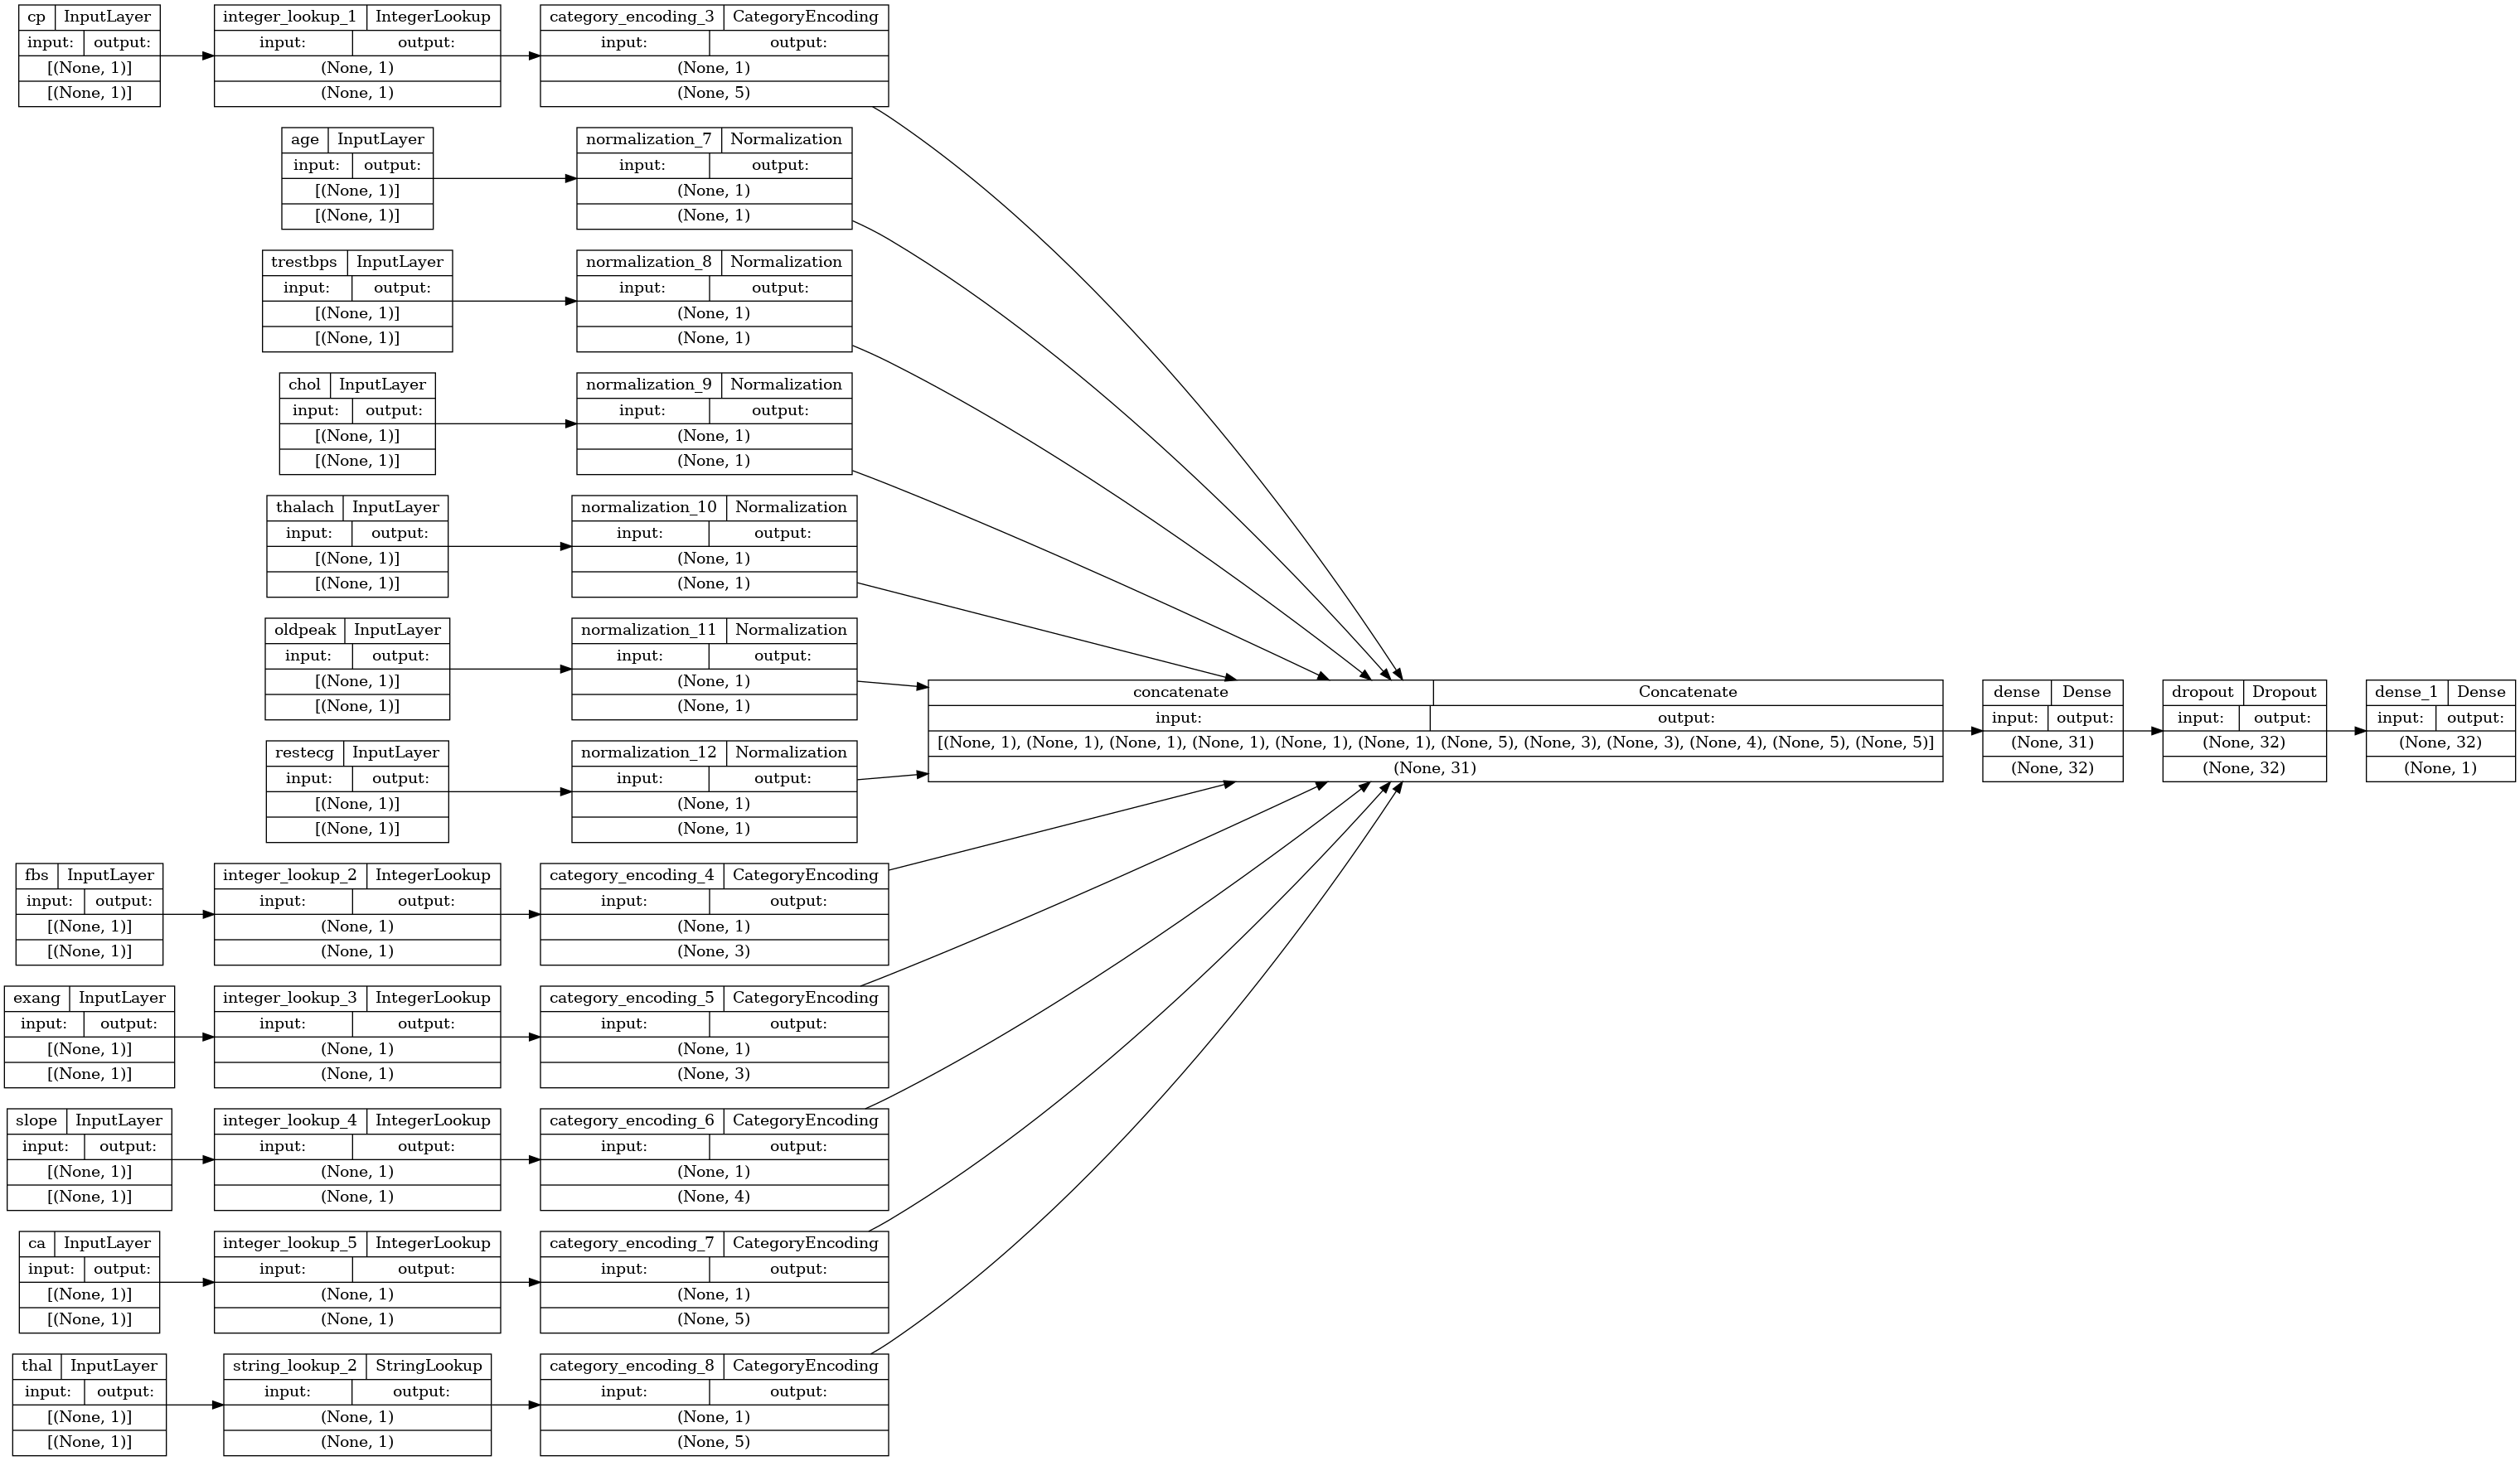

In [52]:
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")


In [53]:
model.fit(train_ds, epochs=10, validation_data=test_ds)

Epoch 1/10


/home/alex/anaconda3/envs/tf/lib/python3.8/site-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['sex', 'target'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


29/29 [==============================] - 3s 33ms/step - loss: 0.6161 - accuracy: 0.7181 - val_loss: 0.5685 - val_accuracy: 0.7632
Epoch 2/10
29/29 [==============================] - 0s 10ms/step - loss: 0.4919 - accuracy: 0.7841 - val_loss: 0.5010 - val_accuracy: 0.7500
Epoch 3/10
29/29 [==============================] - 0s 11ms/step - loss: 0.4666 - accuracy: 0.7841 - val_loss: 0.4637 - val_accuracy: 0.7500
Epoch 4/10
29/29 [==============================] - 0s 10ms/step - loss: 0.4654 - accuracy: 0.8018 - val_loss: 0.4406 - val_accuracy: 0.7763
Epoch 5/10
29/29 [==============================] - 0s 11ms/step - loss: 0.4233 - accuracy: 0.7841 - val_loss: 0.4187 - val_accuracy: 0.7632
Epoch 6/10
29/29 [==============================] - 0s 11ms/step - loss: 0.3934 - accuracy: 0.8238 - val_loss: 0.4077 - val_accuracy: 0.7632
Epoch 7/10
29/29 [==============================] - 0s 10ms/step - loss: 0.3708 - accuracy: 0.8238 - val_loss: 0.3994 - val_accuracy: 0.7763
Epoch 8/10
29/29 [======

# Evaluate

In [54]:
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)

10/10 [==============================] - 0s 7ms/step - loss: 0.3855 - accuracy: 0.7632
Accuracy 0.7631579041481018


# Export

Now we can export the model (which includes all the preprocessing steps) to the [SaveModel format](https://www.tensorflow.org/guide/saved_model). This can then later be imported elsewhere, f.ex. for model deployment using [TensorFlow Serving](https://www.tensorflow.org/tfx/guide/serving) or similar. 

In [ ]:
#?tf.keras.models.save_model

> We'll look more at this when we talk about TensorFlow Extended later in the module.

# Extra: Train a tree-based model

We could alternatively use the TensorFlow Decision Forests library, which can use a collection of state-of-the-art algorithm,s for training, serving and interpreting decision forest models (random forest, gradient boosted trees, etc):

https://github.com/google/yggdrasil-decision-forests

In [ ]:
if colab or gradient:
    !pip install tensorflow_decision_forests

In [55]:
import tensorflow_decision_forests as tfdf

In [56]:
train_ds_trees = tfdf.keras.pd_dataframe_to_tf_dataset(train, label="target")
test_ds_trees = tfdf.keras.pd_dataframe_to_tf_dataset(test, label="target")

/home/alex/anaconda3/envs/tf/lib/python3.8/site-packages/tensorflow_decision_forests/keras/core.py:2036: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  features_dataframe = dataframe.drop(label, 1)
/home/alex/anaconda3/envs/tf/lib/python3.8/site-packages/tensorflow_decision_forests/keras/core.py:2036: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  features_dataframe = dataframe.drop(label, 1)


In [57]:
model = tfdf.keras.RandomForestModel()

Use /tmp/tmp1f7ajvfe as temporary training directory


In [58]:
model.compile(
    metrics=["accuracy"])

In [59]:
model.fit(train_ds_trees)

Starting reading the dataset
1/1 [==============================] - ETA: 0s
Dataset read in 0:00:03.880873
Training model
Model trained in 0:00:00.037966
Compiling model
1/1 [==============================] - 4s 4s/step


[INFO kernel.cc:1153] Loading model from path
[INFO abstract_model.cc:1063] Engine "RandomForestOptPred" built
[INFO kernel.cc:1001] Use fast generic engine


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [60]:
model.summary()

Model: "random_forest_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (13):
	age
	ca
	chol
	cp
	exang
	fbs
	oldpeak
	restecg
	sex
	slope
	thal
	thalach
	trestbps

No weights

Variable Importance: MEAN_MIN_DEPTH:
    1.  "__LABEL"  4.764778 ################
    2.      "fbs"  4.679417 ###############
    3.  "restecg"  4.616640 ###############
    4.    "exang"  4.455385 #############
    5.      "sex"  4.448540 #############
    6.    "slope"  4.267803 ############
    7.      "age"  4.128370 ###########
    8. "trestbps"  4.079775 ###########
    9.     "chol"  3.820061 #########
   10.  "thalach"  3.617815 ########
   11.       "cp"  2.757968 ##
   12.       "ca"  2.516068 #
   13.     "thal"  2.

In [61]:
model.evaluate(test_ds_trees)

1/1 [==============================] - 0s 493ms/step - loss: 0.0000e+00 - accuracy: 0.8026


[0.0, 0.8026315569877625]

In [62]:
import IPython

In [63]:
IPython.display.HTML(tfdf.model_plotter.plot_model(model, tree_idx=0, max_depth=3))

## Evaluate

In [64]:
model.make_inspector().variable_importances()

{'NUM_NODES': [("oldpeak" (1; #6), 763.0),
  ("chol" (1; #2), 658.0),
  ("thalach" (1; #11), 630.0),
  ("ca" (1; #1), 526.0),
  ("age" (1; #0), 488.0),
  ("trestbps" (1; #12), 449.0),
  ("cp" (1; #3), 387.0),
  ("thal" (4; #10), 323.0),
  ("slope" (1; #9), 150.0),
  ("restecg" (1; #7), 141.0),
  ("exang" (1; #4), 118.0),
  ("sex" (1; #8), 109.0),
  ("fbs" (1; #5), 45.0)],
 'NUM_AS_ROOT': [("thal" (4; #10), 87.0),
  ("oldpeak" (1; #6), 64.0),
  ("ca" (1; #1), 58.0),
  ("cp" (1; #3), 57.0),
  ("slope" (1; #9), 11.0),
  ("thalach" (1; #11), 11.0),
  ("exang" (1; #4), 8.0),
  ("sex" (1; #8), 2.0),
  ("age" (1; #0), 1.0),
  ("trestbps" (1; #12), 1.0)],
 'MEAN_MIN_DEPTH': [("__LABEL" (4; #13), 4.764778163758044),
  ("fbs" (1; #5), 4.679416696994099),
  ("restecg" (1; #7), 4.616640037135783),
  ("exang" (1; #4), 4.455384677528641),
  ("sex" (1; #8), 4.448539617718026),
  ("slope" (1; #9), 4.2678027557381295),
  ("age" (1; #0), 4.128369699887889),
  ("trestbps" (1; #12), 4.07977548490668),
  (

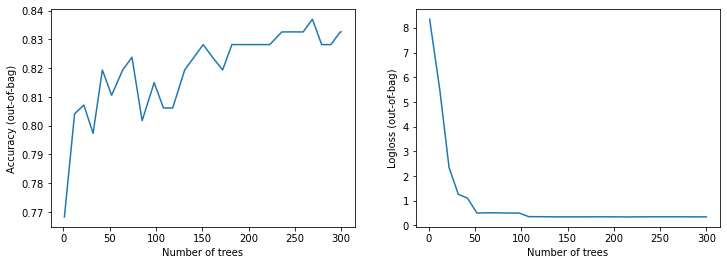

In [65]:
import matplotlib.pyplot as plt

logs = model.make_inspector().training_logs()

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Accuracy (out-of-bag)")

plt.subplot(1, 2, 2)
plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Logloss (out-of-bag)")

plt.show()


## Export

This model can also be exported to a SavedModel, and then served using TensorFlow Serving or similar.

https://www.tensorflow.org/decision_forests/tensorflow_serving

In [ ]:
#model.save("rf_model")